# Employee Activity Report

### Loading Dataset

In [243]:
import pandas as pd
import numpy as np
file_path = 'C:/Users/14704/Desktop/Presentation/MetroPolitican State University/Employer Activity Report - Aug 2022 to Aug 2025.xlsx'
df = pd.read_excel(file_path)

### Overview of Dataset

#### Missing Values in Organization Name

In [244]:
missing_count = df['Organization Name'].isna().sum()
print("Missing Organization values:", missing_count)

Missing Organization values: 0


#### Dulicates Values in Organization Name

In [245]:
# Count unique organizations that have duplicates
duplicate_unique_count = (df['Organization Name'].value_counts() > 1).sum()
print("Number of organizations with duplicates:", duplicate_unique_count)

Number of organizations with duplicates: 66


#### Changing None with "0" in Monthly Engagment column othewise python will treat this as empty

In [246]:
import pandas as pd

# Replace None with 0 in 'Monthly Engagement' column
df['Monthly Engagement'] = df['Monthly Engagement'].fillna(1)

#### Checking Missing Values in Whole Dataset

In [247]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]
print("Missing Values in Each Column:")
print(missing_values)


Missing Values in Each Column:
Industry             135
Industry Cluster     109
Last Login          1145
dtype: int64


#### Making another column related to Monthly Engagement in which High = 3, Medium = 2 and None = 0

In [248]:
# Mapping
engagement_map = {'High': 2, 'Medium': 1, 'None': 0}  # None as 0

# Function to sum values
def sum_engagement(cell):
    cell = str(cell)  # ensure it's a string
    levels = [x.strip() for x in cell.split(',')]
    values = [engagement_map.get(x, 0) for x in levels]  # default 0 if not found
    return sum(values)

# Apply
df['Engagement_Sum'] = df['Monthly Engagement'].apply(sum_engagement)



#### Multipling Total Engagment(Engagment:Total with Engagment_Sum)

In [250]:
df['weighted_Engagment'] = df['Engagement_Sum'] * df['Engagement: Total']
#save to new Excel file
df.to_excel ("engagment_with_Sum.xlsx",index=False)
print("Data saved to 'engagment_with_Sum.xlsx'")

Data saved to 'engagment_with_Sum.xlsx'


### Using Machine Learning Technique to Predict Missing values

#### Loading Libraries 

#### Features and Target

In [251]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class ColumnTo1D(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        # If X is a DataFrame, take first column
        if hasattr(X, 'iloc'):
            return X.iloc[:, 0]
        # If X is a NumPy array, flatten
        elif isinstance(X, np.ndarray):
            return X.ravel()
        else:
            raise ValueError("Unsupported input type: {}".format(type(X)))


In [252]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

preprocessor = ColumnTransformer(
    transformers=[
        ('name_tfidf', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='')),
            ('to_1d', ColumnTo1D()),       # safe flatten
            ('tfidf', TfidfVectorizer())
        ]), ['Organization Name']),
        
        ('industry_ohe', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
            ('ohe', OneHotEncoder(handle_unknown='ignore'))
        ]), ['Industry'])
    ]
)

clf = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train
clf.fit(X_train, y_train)

# Predict missing values
predicted_clusters = clf.predict(X_predict)

# Fill missing values
df.loc[df['Industry Cluster'].isna(), 'Industry Cluster'] = predicted_clusters

print("All missing Industry Cluster values filled successfully!")


All missing Industry Cluster values filled successfully!


In [253]:
import pandas as pd

# Save the updated DataFrame to Excel
df.to_excel("updated_dataset.xlsx", index=False)

print("Excel file 'updated_dataset.xlsx' has been saved successfully!")


Excel file 'updated_dataset.xlsx' has been saved successfully!


## Now Moving Towards the Question

#### How many Employee partners are engaged?

In [254]:
import pandas as pd

# Create a new DataFrame without duplicates in Organization Name
dataframe = df.drop_duplicates(subset=["Organization Name"], keep="first").reset_index(drop=True)
dataframe.to_excel("Organization_Name.xlsx", index=False)
#count number of unique organizations
num_unique_organizations = dataframe.shape[0]
print(f"Number of unique organizations: {num_unique_organizations}")
print("Excel file 'Organization_Name.xlsx' has been saved successfully!")


Number of unique organizations: 2803
Excel file 'Organization_Name.xlsx' has been saved successfully!


Total Entries: 2883
Total Engaged Partners (Unique Orgs): 2803


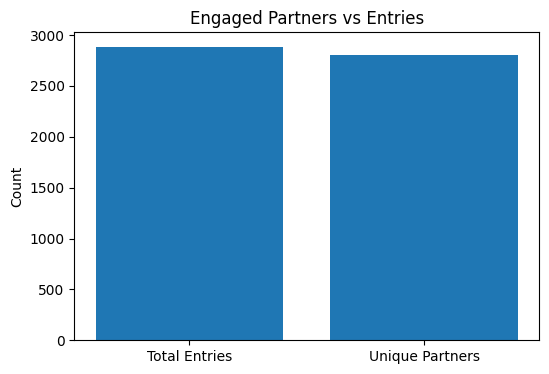

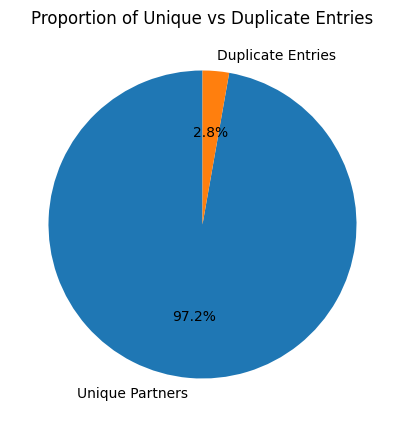

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Total number of entries
total_entries = df["Organization Name"].count()

# Total engaged partners (unique organizations)
unique_partners = df["Organization Name"].nunique()

print("Total Entries:", total_entries)
print("Total Engaged Partners (Unique Orgs):", unique_partners)

# ---- Visualization ----
# Bar chart
plt.figure(figsize=(6,4))
plt.bar(["Total Entries", "Unique Partners"], [total_entries, unique_partners])
plt.title("Engaged Partners vs Entries")
plt.ylabel("Count")
plt.show()

# Pie chart
plt.figure(figsize=(5,5))
plt.pie([unique_partners, total_entries - unique_partners],
        labels=["Unique Partners", "Duplicate Entries"],
        autopct="%1.1f%%", startangle=90)
plt.title("Proportion of Unique vs Duplicate Entries")
plt.show()


#### How strongly they are engaged? Techical Question

#### Next we are merging the duplicates entries into single row to answer other questies.

#### Note: Make sure Industry Cluster name is coming once in new dataset

In [256]:
import pandas as pd

# Group by Organization Name
result = (
    dataframe.groupby("Organization Name", as_index=False)
      .agg({
          "Industry Cluster": lambda x: ', '.join(sorted(set(x.dropna()))),  # join all unique clusters
          "weighted_Engagment": "sum"                                       # sum numeric values
      })
)

# Save to Excel
result.to_excel("Final_Grouped_Organization.xlsx", index=False)



#### How strogly they are engaged?

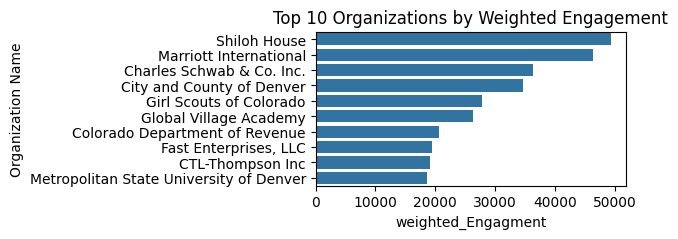

In [259]:
topN = result.sort_values("weighted_Engagment", ascending=False).head(10)

plt.figure(figsize=(4,2))
sns.barplot(x="weighted_Engagment", y="Organization Name", data=topN)
plt.title("Top 10 Organizations by Weighted Engagement")
plt.show()



C:\Users\14704\AppData\Local\Temp\ipykernel_19760\1591108927.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="weighted_Engagment", y="Organization Name", data=topN, palette="viridis")


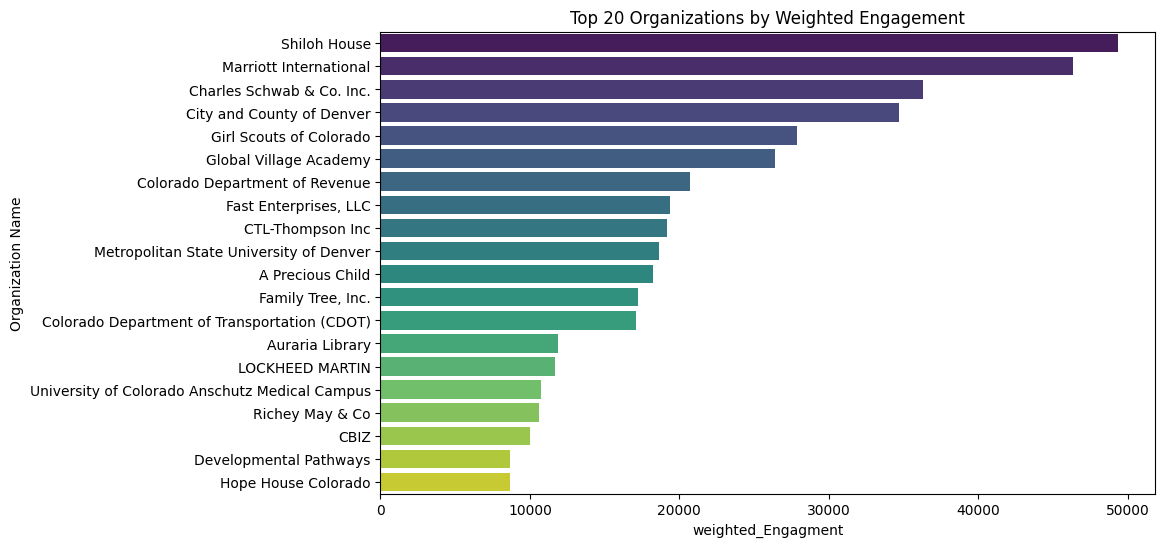

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

topN = result.sort_values("weighted_Engagment", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x="weighted_Engagment", y="Organization Name", data=topN, palette="viridis")
plt.title("Top 20 Organizations by Weighted Engagement")
plt.show()


C:\Users\14704\AppData\Local\Temp\ipykernel_19760\797940148.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(df_top["Organization Name"], rotation=45, ha="right", fontsize=7)


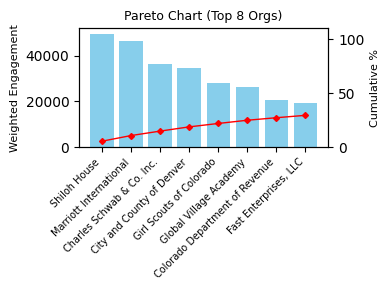

In [269]:
import numpy as np
import matplotlib.pyplot as plt

# Sort and calculate cumulative percentage
df_sorted = result.sort_values("weighted_Engagment", ascending=False)
df_sorted["cumperc"] = df_sorted["weighted_Engagment"].cumsum() / df_sorted["weighted_Engagment"].sum() * 100

# Limit to Top 8 for compact slide view
top_n = 8
df_top = df_sorted.head(top_n)

# Create smaller figure for slide
fig, ax1 = plt.subplots(figsize=(4,3))  # much smaller

# Bar chart
ax1.bar(df_top["Organization Name"], df_top["weighted_Engagment"], color="skyblue")
ax1.set_xticklabels(df_top["Organization Name"], rotation=45, ha="right", fontsize=7)
ax1.set_ylabel("Weighted Engagement", fontsize=8)

# Line chart (cumulative %)
ax2 = ax1.twinx()
ax2.plot(df_top["Organization Name"], df_top["cumperc"], color="red", marker="D", ms=3, linewidth=1)
ax2.set_ylabel("Cumulative %", fontsize=8)
ax2.set_ylim(0, 110)

plt.title("Pareto Chart (Top 8 Orgs)", fontsize=9)
plt.tight_layout()
plt.show()



In [204]:
import pandas as pd

# Aggregate engagement by organization
org_engagement = result.groupby("Organization Name")["weighted_Engagment"].sum()

# Calculate percentage
org_engagement_percent = (org_engagement / org_engagement.sum()) * 100

# Keep top 20 and combine the rest as 'Others'
top_n = 20
top_orgs = org_engagement_percent.sort_values(ascending=False).head(top_n)
others = pd.Series([100 - top_orgs.sum()], index=["Others"])

# Combine top 20 with Others
final_percent = pd.concat([top_orgs, others])



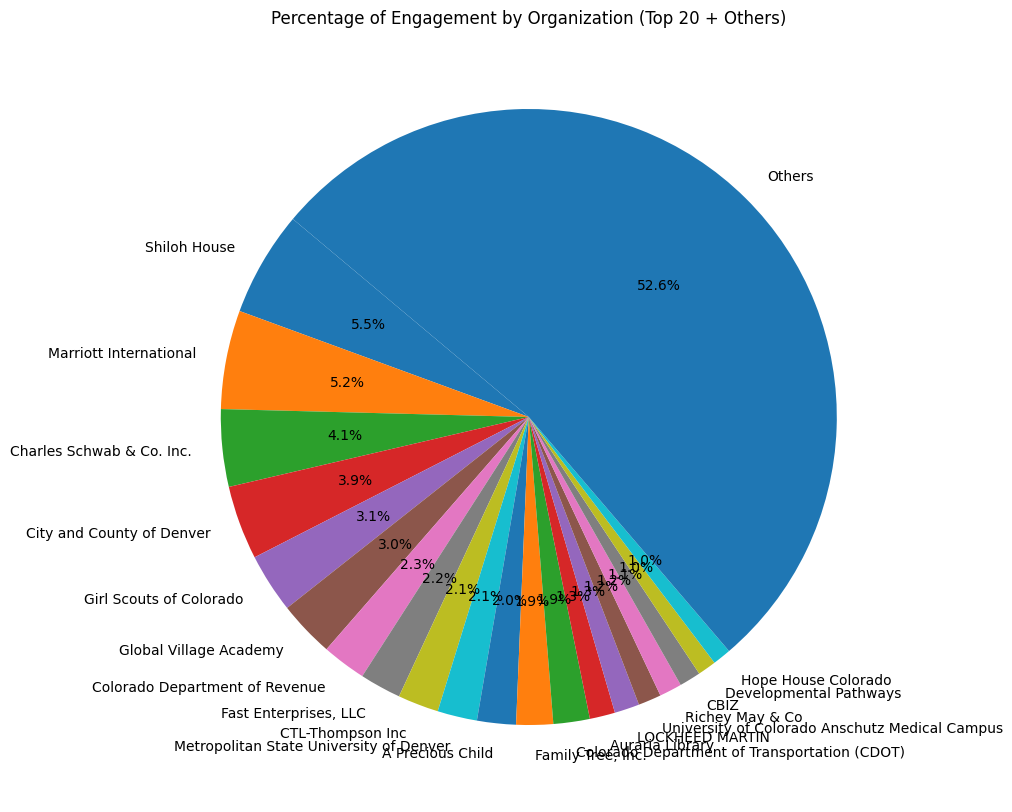

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.pie(final_percent, labels=final_percent.index, autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Engagement by Organization (Top 20 + Others)")
plt.show()


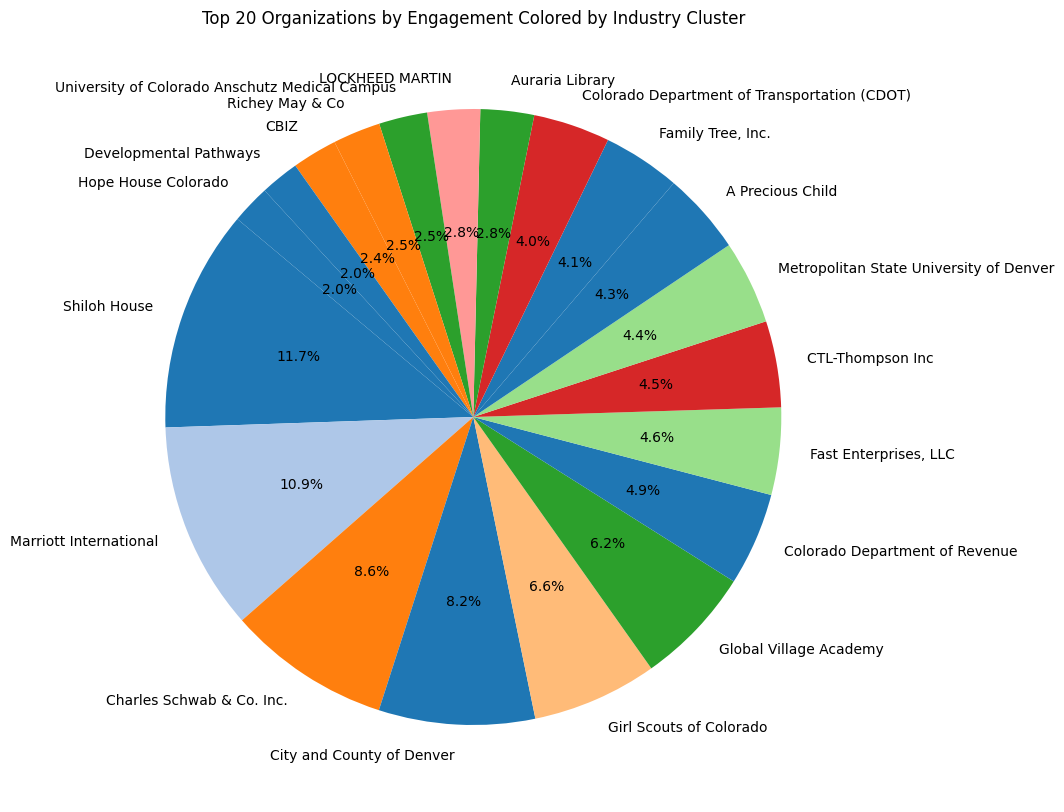

In [209]:
# Exclude 'Others' for plotting
plot_data = top_orgs[top_orgs.index != "Others"]

# Filter organization names for colors
plot_org_names = plot_data.index.tolist()

# Map clusters only for actual organizations (exclude Others)
top_org_clusters = result[result["Organization Name"].isin(plot_org_names)][["Organization Name", "Industry Cluster"]].drop_duplicates()
top_org_clusters = top_org_clusters.set_index("Organization Name").loc[plot_org_names]

# Prepare colors for clusters
clusters = top_org_clusters["Industry Cluster"].unique()
colors = plt.cm.tab20.colors  # 20 distinct colors
cluster_color_map = {cluster: colors[i % 20] for i, cluster in enumerate(clusters)}
org_colors = [cluster_color_map[top_org_clusters.loc[org, "Industry Cluster"]] for org in plot_org_names]

# Plot pie chart
plt.figure(figsize=(10,10))
plt.pie(plot_data, labels=plot_org_names, autopct='%1.1f%%',
        startangle=140, colors=org_colors)
plt.title("Top 20 Organizations by Engagement Colored by Industry Cluster")
plt.show()





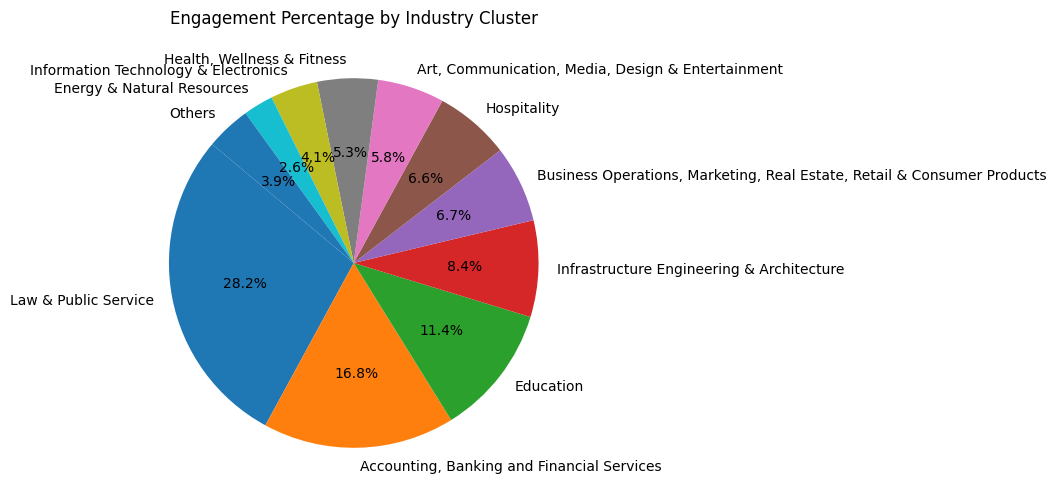

In [271]:
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate engagement by Industry Cluster
industry_engagement = result.groupby("Industry Cluster")["weighted_Engagment"].sum()

# Calculate percentages
industry_percent = (industry_engagement / industry_engagement.sum()) * 100

# Optional: if too many clusters, keep top 10 and combine the rest as 'Others'
top_n = 10
top_industries = industry_percent.sort_values(ascending=False).head(top_n)
others = pd.Series([100 - top_industries.sum()], index=["Others"])
final_industry_percent = pd.concat([top_industries, others])

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(final_industry_percent, labels=final_industry_percent.index, autopct='%1.1f%%', startangle=140)
plt.title("Engagement Percentage by Industry Cluster")
plt.show()


In [213]:
avg_engagement = result['weighted_Engagment'].mean()
print(f"Average engagement strength: {avg_engagement}")


Average engagement strength: 319.06136282554405


In [280]:
low = result['weighted_Engagment'].quantile(0.33)
high = result['weighted_Engagment'].quantile(0.66)

def engagement_level(score):
    if score <= low:
        return 'Low'
    elif score <= high:
        return 'Medium'
    else:
        return 'High'

result['Engagement_Level'] = result['weighted_Engagment'].apply(engagement_level)
#save result to excel
result.to_excel("Final_Grouped_Engagment_Organization.xlsx", index=False)

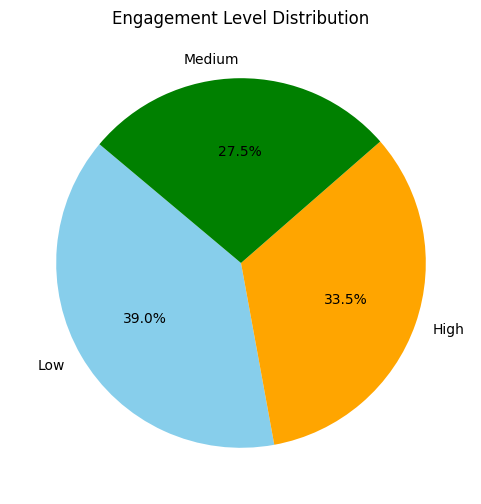

In [282]:
import matplotlib.pyplot as plt

# Count of each engagement level
level_counts = result['Engagement_Level'].value_counts()

# Define colors for each level
colors = ['skyblue', 'orange', 'green']  # Low, Medium, High

# Plot pie chart
plt.figure(figsize=(6,6))
plt.pie(level_counts, labels=level_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Engagement Level Distribution')
plt.show()



   Engagement_Level                                   Industry Cluster  Count
0              High         Accounting, Banking and Financial Services     86
1              High  Accounting, Banking and Financial Services, La...      2
2              High                             Advanced Manufacturing     21
3              High  Advanced Manufacturing, Aerospace & Aviation, ...      1
4              High                               Aerospace & Aviation     16
..              ...                                                ...    ...
59           Medium          Infrastructure Engineering & Architecture     56
60           Medium                               Law & Public Service    166
61           Medium         Real Estate, Housing, and Housing Services     22
62           Medium                                                TBD     22
63           Medium              Transportation & Logistics (archived)     17

[64 rows x 3 columns]


C:\Users\14704\AppData\Local\Temp\ipykernel_19760\3837454657.py:16: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


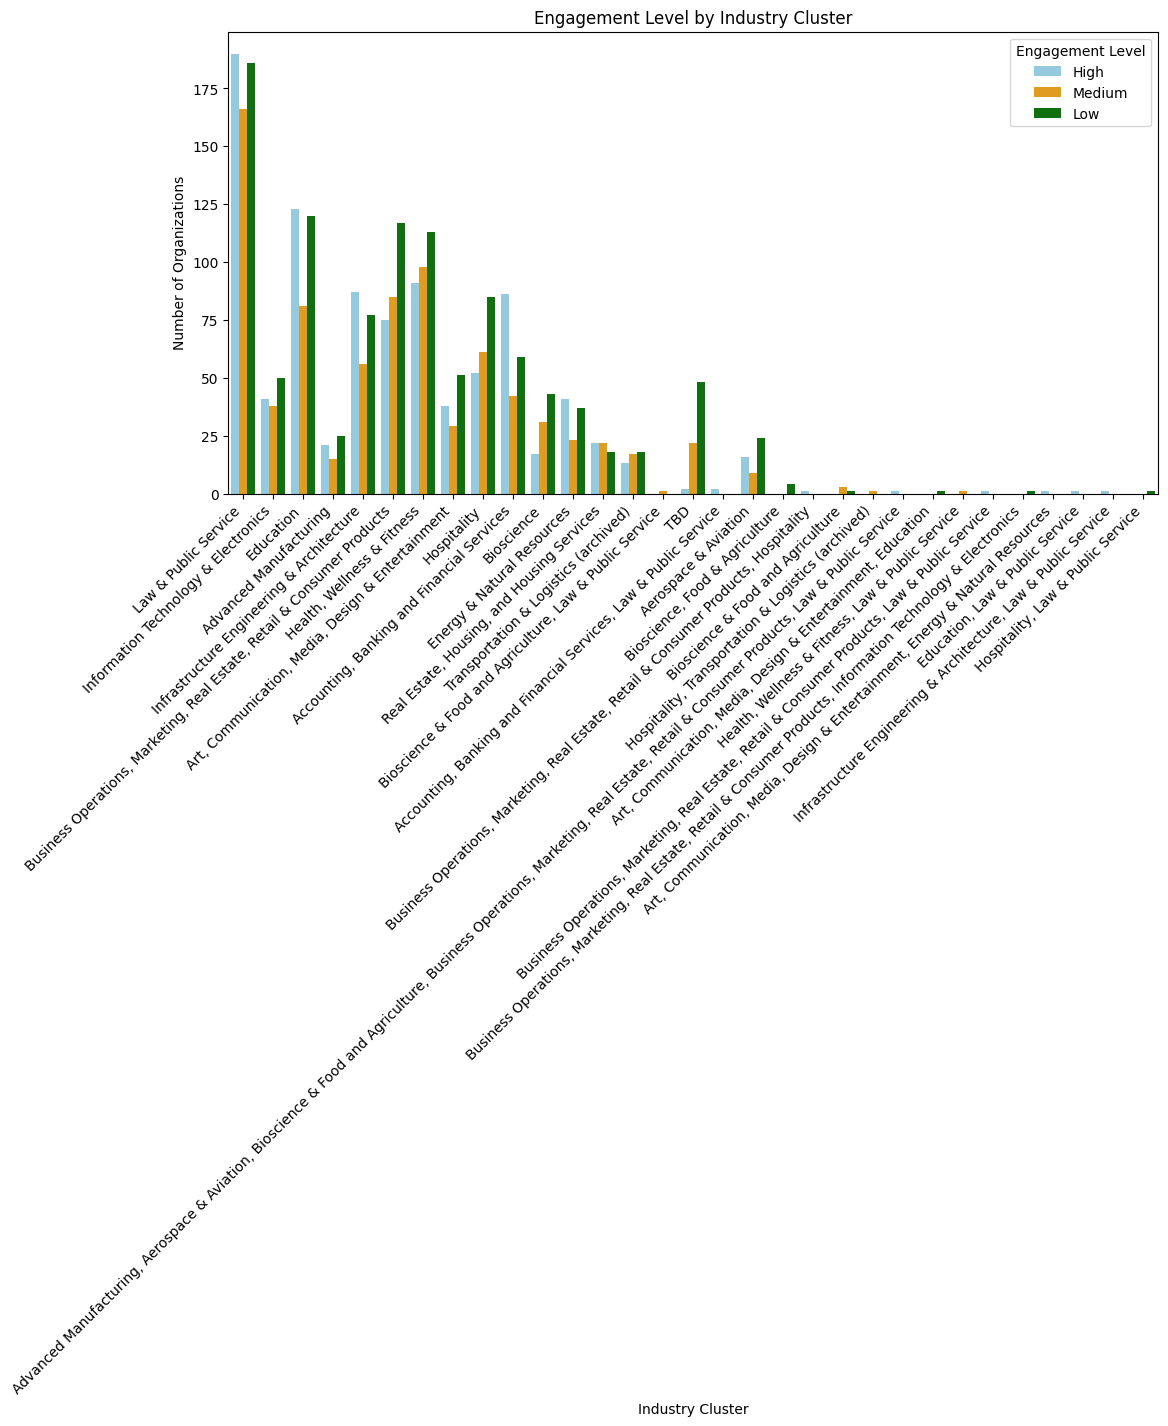

In [240]:
# Group by Engagement Level and Industry Cluster
industry_engagement = result.groupby(['Engagement_Level', 'Industry Cluster']).size().reset_index(name='Count')

# Preview the result
print(industry_engagement)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
sns.countplot(data=result, x='Industry Cluster', hue='Engagement_Level', palette=['skyblue','orange','green'])
plt.xticks(rotation=45, ha='right')
plt.title('Engagement Level by Industry Cluster')
plt.xlabel('Industry Cluster')
plt.ylabel('Number of Organizations')
plt.legend(title='Engagement Level')
plt.tight_layout()
plt.show()
